# Commitment Across Distance Conditions — 2P3G

This notebook analyzes commitment across distance conditions for 2P3G trials,
using helper logic adapted from `commitment_across_distance_conditions_clean.ipynb` to:
- Reconstruct player positions at the new-goal moment.
- Validate that distance conditions reflect the true distances to the new goal.
- Compute commitment rates across partner types: human–human, human–GPT, human–individual RL, and human–joint RL.

In [178]:
from pathlib import Path
import pandas as pd
import numpy as np
import ast
import glob
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
BASE = Path('.')  # assume running from dataAnalysis/
PATH_HH_GPT = BASE / 'human-human-with-gpt-fallback' / 'combined_experiment_data.csv'
PATH_HH_GPT_XLSX_DIR = BASE / 'human-human-with-gpt-fallback' / 'data-original'
PATH_RL_DIR = BASE / 'human-RLs' / 'data-original'

print('Paths:')
print('  human-human/GPT combined:', PATH_HH_GPT.resolve())
print('  HH/GPT xlsx dir:', PATH_HH_GPT_XLSX_DIR.resolve())
print('  RL xlsx dir:', PATH_RL_DIR.resolve())

Paths:
  human-human/GPT combined: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-human-with-gpt-fallback/combined_experiment_data.csv
  HH/GPT xlsx dir: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-human-with-gpt-fallback/data-original
  RL xlsx dir: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-RLs/data-original


In [179]:
# Extra path for HH/GPT raw Excel fallback
PATH_HH_GPT_XLSX_DIR = BASE / 'human-human-with-gpt-fallback' / 'data-original'
print('  HH/GPT xlsx dir:', PATH_HH_GPT_XLSX_DIR.resolve())


  HH/GPT xlsx dir: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-human-with-gpt-fallback/data-original


## Helper Functions (from cleaned distance notebook)
Copied/adapted from `commitment_across_distance_conditions_clean.ipynb` to ensure identical distance reconstruction logic.

In [180]:
def parse_point(value):
    if value is None:
        return None
    s = str(value).strip()
    if s == '' or s in {'[]'}:
        return None
    if s.lower() in {'nan', 'none', 'null'}:
        return None
    try:
        return tuple(ast.literal_eval(s))
    except Exception:
        return None

def parse_positions(value):
    if value is None:
        return []
    s = str(value).strip()
    if s == '' or s == '[]':
        return []
    try:
        return [tuple(x) for x in ast.literal_eval(s)]
    except Exception:
        return []

def compress_positions(seq):
    out = []
    for p in seq:
        if not out or p != out[-1]:
            out.append(p)
    return out

def get_human_pos_at_new(row):
    step_val = row.get('newGoalPresentedTime')
    if step_val in (None, ''):
        return None
    step = int(float(step_val))
    traj = parse_positions(row.get('player1Trajectory'))
    if step < len(traj):
        return traj[step]
    # fallback: reconstruct from init + actions if available
    pos = parse_point(row.get('initPlayerGrid'))
    actions = parse_positions(row.get('player1Actions'))
    if pos is None or not actions:
        return traj[-1] if traj else None
    for idx, act in enumerate(actions, start=1):
        pos = (pos[0] + act[0], pos[1] + act[1])
        if idx == step:
            return pos
    return pos

def get_ai_pos_at_new(row):
    step_val = row.get('newGoalPresentedTime')
    if step_val in (None, ''):
        return None
    step = int(float(step_val))
    traj = parse_positions(row.get('player2Trajectory'))
    if not traj:
        # Fallback to initial AI grid if present
        return parse_point(row.get('initAIGrid'))
    # Prefer AI state after each human step: odd indices 1,3,5,...
    odd_positions = [traj[i] for i in range(1, len(traj), 2)]
    if odd_positions:
        idx = min(step, len(odd_positions)-1)
        return odd_positions[idx]
    # Fallback: clamp 2*step-1 into raw trajectory
    idx = max(0, min(len(traj)-1, 2*step - 1))
    return traj[idx]

def get_goal_index_at_new(row, step):
    # Check player1CurrentGoal then player2CurrentGoal for a non-null index at (step-1)
    for col in ('player1CurrentGoal', 'player2CurrentGoal'):
        raw = row.get(col)
        if not raw:
            continue
        raw = str(raw).replace('null', 'None')
        try:
            arr = ast.literal_eval(raw)
        except Exception:
            continue
        if not isinstance(arr, list) or not arr:
            continue
        idx = max(0, min(step-1, len(arr)-1))
        val = arr[idx]
        if val is not None:
            try:
                return int(val)
            except Exception:
                pass
    return 0

def manhattan(a, b):
    if a is None or b is None:
        return np.nan
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


## Load Datasets (2P3G only)
- human–human and human–GPT from `human-human-with-gpt-fallback/combined_experiment_data.csv`
- human–RL from all xlsx files under `human-RLs/data-original/` (expects `rlAgentType` column)

In [181]:
# Human–Human / Human–GPT combined CSV
df_hh_gpt = pd.read_csv(PATH_HH_GPT)
df_hh_gpt = df_hh_gpt[df_hh_gpt['experimentType'] == '2P3G'].copy()
print('HH/GPT 2P3G rows:', len(df_hh_gpt))
print('Partner types (HH/GPT):', sorted(df_hh_gpt['partnerAgentType'].dropna().unique().tolist()))

# RL experiments — combine all xlsx
rl_files = sorted(glob.glob(str(PATH_RL_DIR / 'experiment_data_*.xlsx')))
dfs = []
for f in rl_files:
    try:
        dfi = pd.read_excel(f)
        dfi['source_file'] = Path(f).name
        dfs.append(dfi)
    except Exception as e:
        print('Failed reading', f, e)

df_rl = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
df_rl = df_rl[df_rl['experimentType'] == '2P3G'].copy() if not df_rl.empty else df_rl
print('RL 2P3G rows:', (0 if df_rl is None or len(df_rl)==0 else len(df_rl)))
print('RL types (if present):', (sorted(df_rl['rlAgentType'].dropna().unique().tolist()) if not df_rl.empty and 'rlAgentType' in df_rl.columns else []))

# Annotate partner type labels to unify across sources
def label_partner_type(row):
    pat = str(row.get('partnerAgentType', '')).strip().lower()
    if pat == 'human':
        return 'human_human'
    if 'gpt' in pat:  # matches 'gpt-4.1-mini', 'gpt-4o', etc.
        return 'human_gpt'
    rat = row.get('rlAgentType')
    if pd.notna(rat):
        r = str(rat).strip().lower()
        if r == 'individual':
            return 'individual_rl'
        if r == 'joint':
            return 'joint_rl'
    return 'unknown'

df_hh_gpt['partner_group'] = df_hh_gpt.apply(label_partner_type, axis=1)
if not df_rl.empty:
    df_rl['partner_group'] = df_rl.apply(label_partner_type, axis=1)

print('Groups HH/GPT:', df_hh_gpt['partner_group'].value_counts().to_dict())
if not df_rl.empty:
    print('Groups RL:', df_rl['partner_group'].value_counts().to_dict())

HH/GPT 2P3G rows: 524
Partner types (HH/GPT): ['gpt-4.1-mini', 'human']
RL 2P3G rows: 720
RL types (if present): ['individual', 'joint']
Groups HH/GPT: {'human_human': 343, 'human_gpt': 181}
Groups RL: {'individual_rl': 360, 'joint_rl': 360}


In [182]:
# Fallback: If HH/GPT 2P3G is missing from combined CSV, load from raw xlsx files
if 'df_hh_gpt' in globals() and (df_hh_gpt is None or len(df_hh_gpt) == 0):
    print('No HH/GPT 2P3G in combined CSV; loading from raw HH/GPT Excel files...')
    hhgpt_files = sorted(glob.glob(str(PATH_HH_GPT_XLSX_DIR / 'experiment_data_*.xlsx')))
    raw_list = []
    for f in hhgpt_files:
        try:
            dfi = pd.read_excel(f)
            dfi['source_file'] = Path(f).name
            raw_list.append(dfi)
        except Exception as e:
            print('Failed reading', f, e)
    df_hh_gpt = pd.concat(raw_list, ignore_index=True) if raw_list else pd.DataFrame()
    if not df_hh_gpt.empty and 'experimentType' in df_hh_gpt.columns:
        df_hh_gpt = df_hh_gpt[df_hh_gpt['experimentType'] == '2P3G'].copy()
    print('HH/GPT 2P3G rows (fallback):', len(df_hh_gpt))

# Ensure partner_group exists and captures GPT properly
if 'df_hh_gpt' in globals() and not df_hh_gpt.empty:
    def _label_partner_type(row):
        pat = str(row.get('partnerAgentType', '')).strip().lower()
        if pat == 'human':
            return 'human_human'
        if any(k in pat for k in ['gpt', 'gpt-4', 'gpt4']):
            return 'human_gpt'
        rat = str(row.get('rlAgentType', '')).strip().lower()
        if rat == 'individual':
            return 'individual_rl'
        if rat == 'joint':
            return 'joint_rl'
        return 'unknown'
    df_hh_gpt['partner_group'] = df_hh_gpt.apply(_label_partner_type, axis=1)
    print('Groups HH/GPT:', df_hh_gpt['partner_group'].value_counts().to_dict())


Groups HH/GPT: {'human_human': 343, 'human_gpt': 181}


## Infer Missing Target Positions for HH/GPT (2P3G)
Rules:
- If `playerXFinalReachedGoal` is 0 or 1, infer that goal's position as last position plus last action: `traj[-1] + action[-1]`.
- If only one original target known, infer the other by symmetry across the midpoint of initial player positions.
- Initial positions from trajectories: `init_p1 = player1Trajectory[0]`, `init_p2 = player2Trajectory[0]`.
- If both finals are 2 (new third goal), leave targets empty for that trial.


In [183]:
# This cell is superseded by the corrected inference function below.
# Keeping a lightweight wrapper to avoid double assignment issues.

def _ensure_hh_gpt_targets(df):
    return df

df_hh_gpt = _ensure_hh_gpt_targets(df_hh_gpt)
print('Skipped old inference (using corrected version in next cell).')


Skipped old inference (using corrected version in next cell).


In [184]:
# Corrected: per-row reasons and robust inference

def infer_missing_targets_hh_gpt(df):
    df = df.copy()
    mask_2p3g = df['experimentType'] == '2P3G'
    hh = df[mask_2p3g].copy()

    inferred_t1 = []
    inferred_t2 = []
    reasons_all = []

    for _, row in hh.iterrows():
        row_reasons = []

        # Read existing targets if present
        t1 = _safe_parse_point(row.get('target1') if 'target1' in row else row.get('targetOne'))
        t2 = _safe_parse_point(row.get('target2') if 'target2' in row else row.get('targetTwo'))

        # Trajectories and actions
        p1_traj = _safe_parse_positions(row.get('player1Trajectory'))
        p2_traj = _safe_parse_positions(row.get('player2Trajectory'))
        a1_seq = _safe_parse_positions(row.get('player1Actions'))
        a2_seq = _safe_parse_positions(row.get('player2Actions'))

        init_p1 = p1_traj[0] if p1_traj else None
        init_p2 = p2_traj[0] if p2_traj else None
        last_p1 = p1_traj[-1] if p1_traj else None
        last_p2 = p2_traj[-1] if p2_traj else None
        last_a1 = a1_seq[-1] if a1_seq else None
        last_a2 = a2_seq[-1] if a2_seq else None

        g1 = row.get('player1FinalReachedGoal')
        g2 = row.get('player2FinalReachedGoal')
        try:
            g1 = None if pd.isna(g1) else int(float(g1))
            g2 = None if pd.isna(g2) else int(float(g2))
        except Exception:
            pass

        # If both final goals are 2 (new third goal), leave empty
        if g1 == 2 and g2 == 2:
            inferred_t1.append(t1)
            inferred_t2.append(t2)
            reasons_all.append('both_final_2_leave_empty')
            continue

        # Infer from final reached goals (0/1)
        if t1 is None and g1 == 0 and last_p1 is not None and last_a1 is not None:
            t1 = _vector_add(last_p1, last_a1)
            row_reasons.append('infer_t1_from_p1_final0')
        if t2 is None and g1 == 1 and last_p1 is not None and last_a1 is not None:
            t2 = _vector_add(last_p1, last_a1)
            row_reasons.append('infer_t2_from_p1_final1')
        if t1 is None and g2 == 0 and last_p2 is not None and last_a2 is not None:
            t1 = _vector_add(last_p2, last_a2)
            row_reasons.append('infer_t1_from_p2_final0')
        if t2 is None and g2 == 1 and last_p2 is not None and last_a2 is not None:
            t2 = _vector_add(last_p2, last_a2)
            row_reasons.append('infer_t2_from_p2_final1')

        # If exactly one of t1/t2 known and both inits exist, infer the other by symmetry
        if (t1 is not None) ^ (t2 is not None) and init_p1 is not None and init_p2 is not None:
            mid = ((init_p1[0] + init_p2[0]) / 2.0, (init_p1[1] + init_p2[1]) / 2.0)
            if t1 is not None and t2 is None:
                t2 = (int(round(2*mid[0] - t1[0])), int(round(2*mid[1] - t1[1])))
                row_reasons.append('infer_t2_by_symmetry')
            elif t2 is not None and t1 is None:
                t1 = (int(round(2*mid[0] - t2[0])), int(round(2*mid[1] - t2[1])))
                row_reasons.append('infer_t1_by_symmetry')

        inferred_t1.append(t1)
        inferred_t2.append(t2)
        reasons_all.append('|'.join(row_reasons) if row_reasons else 'no_change')

    df.loc[mask_2p3g, 'target1_inferred'] = pd.Series(inferred_t1, index=hh.index)
    df.loc[mask_2p3g, 'target2_inferred'] = pd.Series(inferred_t2, index=hh.index)
    df.loc[mask_2p3g, 'targets_infer_reason'] = pd.Series(reasons_all, index=hh.index)
    return df

# Re-apply with corrected logic
df_hh_gpt = infer_missing_targets_hh_gpt(df_hh_gpt)

# Prefer inferred targets when originals are missing (re-apply)
if 'target1' in df_hh_gpt.columns:
    df_hh_gpt['target1'] = df_hh_gpt['target1'].where(df_hh_gpt['target1'].notna(), df_hh_gpt['target1_inferred'])
elif 'targetOne' in df_hh_gpt.columns:
    df_hh_gpt['target1'] = df_hh_gpt['targetOne'].where(df_hh_gpt['targetOne'].notna(), df_hh_gpt['target1_inferred'])
else:
    # Neither target1 nor targetOne exists, use inferred values
    df_hh_gpt['target1'] = df_hh_gpt['target1_inferred']

if 'target2' in df_hh_gpt.columns:
    df_hh_gpt['target2'] = df_hh_gpt['target2'].where(df_hh_gpt['target2'].notna(), df_hh_gpt['target2_inferred'])
elif 'targetTwo' in df_hh_gpt.columns:
    df_hh_gpt['target2'] = df_hh_gpt['targetTwo'].where(df_hh_gpt['targetTwo'].notna(), df_hh_gpt['target2_inferred'])
else:
    # Neither target2 nor targetTwo exists, use inferred values
    df_hh_gpt['target2'] = df_hh_gpt['target2_inferred']

print('Re-applied target inference (corrected). Reasons sample:')
print(df_hh_gpt['targets_infer_reason'].value_counts().head())


Re-applied target inference (corrected). Reasons sample:
targets_infer_reason
infer_t1_from_p1_final0|infer_t2_by_symmetry    297
infer_t2_from_p1_final1|infer_t1_by_symmetry    127
both_final_2_leave_empty                         67
infer_t1_from_p2_final0|infer_t2_by_symmetry     12
no_change                                         8
Name: count, dtype: int64


## Recompute Distances at New-Goal Moment
Ensures that distanceCondition reflects actual distances to the new goal at `newGoalPresentedTime`.

In [185]:
def compute_distances(df):
    df = df.copy()
    human_pos = []
    partner_pos = []
    old_goals = []
    new_goals = []
    first_shared_goal_positions = []

    for _, row in df.iterrows():
        step = int(float(row['newGoalPresentedTime'])) if pd.notna(row.get('newGoalPresentedTime')) else 0
        h = get_human_pos_at_new(row)
        a = get_ai_pos_at_new(row)
        t1 = parse_point(row.get('target1')) if 'target1' in row else parse_point(row.get('targetOne'))
        t2 = parse_point(row.get('target2')) if 'target2' in row else parse_point(row.get('targetTwo'))
        gidx = get_goal_index_at_new(row, step)
        old_goal = (t1, t2)[gidx] if gidx in (0,1) else t1

        # Get first detected shared goal position
        first_shared_idx = row.get('firstDetectedSharedGoal')
        if pd.notna(first_shared_idx):
            try:
                first_shared_idx = int(first_shared_idx)
                first_shared_goal_pos = (t1, t2)[first_shared_idx] if first_shared_idx in (0,1) else None
            except:
                first_shared_goal_pos = None
        else:
            first_shared_goal_pos = None

        human_pos.append(h)
        partner_pos.append(a)
        old_goals.append(old_goal)
        new_goals.append(parse_point(row.get('newGoalPosition')))
        first_shared_goal_positions.append(first_shared_goal_pos)

    df = df.assign(
        human_pos_at_new=human_pos,
        partner_pos_at_new=partner_pos,
        old_goal_at_new=old_goals,
        new_goal=new_goals,
        first_shared_goal_pos=first_shared_goal_positions,
    )
    df = df.assign(
        newGoalDistanceToPlayer1=df.apply(lambda r: manhattan(r['human_pos_at_new'], r['new_goal']), axis=1),
        newGoalDistanceToPlayer2=df.apply(lambda r: manhattan(r['partner_pos_at_new'], r['new_goal']), axis=1),
        humanDistanceToOldGoal=df.apply(lambda r: manhattan(r['human_pos_at_new'], r['old_goal_at_new']), axis=1),
        aiDistanceToOldGoal=df.apply(lambda r: manhattan(r['partner_pos_at_new'], r['old_goal_at_new']), axis=1),
        # Add distances to first shared goal
        humanDistanceToFirstSharedGoal=df.apply(lambda r: manhattan(r['human_pos_at_new'], r['first_shared_goal_pos']), axis=1),
        aiDistanceToFirstSharedGoal=df.apply(lambda r: manhattan(r['partner_pos_at_new'], r['first_shared_goal_pos']), axis=1),
    )
    df['newGoalDistanceSum'] = df['newGoalDistanceToPlayer1'] + df['newGoalDistanceToPlayer2']
    df['oldGoalDistanceSum'] = df['humanDistanceToOldGoal'] + df['aiDistanceToOldGoal']
    df['joint_distance_diff'] = df['newGoalDistanceSum'] - df['oldGoalDistanceSum']
    return df

# Apply to each source
hh_gpt2 = compute_distances(df_hh_gpt[df_hh_gpt['newGoalPresented'] == True])
rl2 = compute_distances(df_rl[df_rl['newGoalPresented'] == True]) if not df_rl.empty else df_rl

print('Computed distances: HH/GPT rows', len(hh_gpt2), '| RL rows', (0 if rl2 is None or len(rl2)==0 else len(rl2)))

Computed distances: HH/GPT rows 390 | RL rows 532


## Diagnose NaN in First Shared Goal Distances
Investigate why some trials have NaN values for first shared goal distances.


In [186]:
print('=== DIAGNOSING NaN IN FIRST SHARED GOAL DISTANCES ===\n')

def diagnose_nan_distances(df, label=''):
    """Diagnose why first shared goal distances are NaN"""
    print(f'[{label}] Analyzing {len(df)} trials')

    # Check firstDetectedSharedGoal column
    has_first_shared = df['firstDetectedSharedGoal'].notna()
    print(f'  firstDetectedSharedGoal present: {has_first_shared.sum()} / {len(df)}')

    if has_first_shared.sum() > 0:
        # Check values
        values = df[has_first_shared]['firstDetectedSharedGoal'].value_counts().sort_index()
        print(f'  firstDetectedSharedGoal values: {values.to_dict()}')

        # Check if targets exist
        has_t1 = df['target1'].notna() if 'target1' in df.columns else df['targetOne'].notna() if 'targetOne' in df.columns else pd.Series([False]*len(df))
        has_t2 = df['target2'].notna() if 'target2' in df.columns else df['targetTwo'].notna() if 'targetTwo' in df.columns else pd.Series([False]*len(df))
        print(f'  target1/targetOne present: {has_t1.sum()} / {len(df)}')
        print(f'  target2/targetTwo present: {has_t2.sum()} / {len(df)}')

        # Check computed distances
        has_human_dist = df['humanDistanceToFirstSharedGoal'].notna()
        has_ai_dist = df['aiDistanceToFirstSharedGoal'].notna()
        print(f'  humanDistanceToFirstSharedGoal computed: {has_human_dist.sum()} / {len(df)}')
        print(f'  aiDistanceToFirstSharedGoal computed: {has_ai_dist.sum()} / {len(df)}')

        # Check for specific issues
        nan_cases = df[df['humanDistanceToFirstSharedGoal'].isna() | df['aiDistanceToFirstSharedGoal'].isna()]
        if len(nan_cases) > 0:
            print(f'\n  Found {len(nan_cases)} trials with NaN distances:')

            # Sample a few cases
            sample = nan_cases.head(3)
            for idx, row in sample.iterrows():
                print(f'\n    Trial {idx}:')
                print(f'      firstDetectedSharedGoal: {row.get("firstDetectedSharedGoal")}')
                print(f'      target1: {row.get("target1") if "target1" in row.index else row.get("targetOne")}')
                print(f'      target2: {row.get("target2") if "target2" in row.index else row.get("targetTwo")}')
                print(f'      first_shared_goal_pos: {row.get("first_shared_goal_pos")}')
                print(f'      human_pos_at_new: {row.get("human_pos_at_new")}')
                print(f'      partner_pos_at_new: {row.get("partner_pos_at_new")}')
                print(f'      humanDistanceToFirstSharedGoal: {row.get("humanDistanceToFirstSharedGoal")}')
                print(f'      aiDistanceToFirstSharedGoal: {row.get("aiDistanceToFirstSharedGoal")}')
    else:
        print('  ⚠️ NO trials have firstDetectedSharedGoal!')

    print()

# Diagnose both datasets
if hh_gpt2 is not None and not hh_gpt2.empty:
    diagnose_nan_distances(hh_gpt2[hh_gpt2['distanceCondition'] == 'equal_to_both'], 'HH/GPT equal_to_both')

if rl2 is not None and not rl2.empty:
    diagnose_nan_distances(rl2[rl2['distanceCondition'] == 'equal_to_both'], 'RL equal_to_both')


=== DIAGNOSING NaN IN FIRST SHARED GOAL DISTANCES ===

[HH/GPT equal_to_both] Analyzing 139 trials
  firstDetectedSharedGoal present: 139 / 139
  firstDetectedSharedGoal values: {0.0: 101, 1.0: 37, 2.0: 1}
  target1/targetOne present: 119 / 139
  target2/targetTwo present: 119 / 139
  humanDistanceToFirstSharedGoal computed: 119 / 139
  aiDistanceToFirstSharedGoal computed: 119 / 139

  Found 20 trials with NaN distances:

    Trial 754:
      firstDetectedSharedGoal: 0.0
      target1: None
      target2: None
      first_shared_goal_pos: None
      human_pos_at_new: (4, 8)
      partner_pos_at_new: (4, 8)
      humanDistanceToFirstSharedGoal: nan
      aiDistanceToFirstSharedGoal: nan

    Trial 792:
      firstDetectedSharedGoal: 1.0
      target1: None
      target2: None
      first_shared_goal_pos: None
      human_pos_at_new: (12, 8)
      partner_pos_at_new: (12, 8)
      humanDistanceToFirstSharedGoal: nan
      aiDistanceToFirstSharedGoal: nan

    Trial 848:
      firstDetec

In [187]:
# Additional check: Is firstDetectedSharedGoal missing from the SOURCE data?
print('=== CHECKING SOURCE DATA FOR firstDetectedSharedGoal ===\n')

print('[HH/GPT Source Data]')
if 'firstDetectedSharedGoal' in df_hh_gpt.columns:
    print(f'  Column exists: YES')
    print(f'  Non-null values: {df_hh_gpt["firstDetectedSharedGoal"].notna().sum()} / {len(df_hh_gpt)}')
    print(f'  Value distribution:')
    print(df_hh_gpt['firstDetectedSharedGoal'].value_counts().sort_index())
    print(f'\n  By experimentType:')
    for exp_type in df_hh_gpt['experimentType'].unique():
        subset = df_hh_gpt[df_hh_gpt['experimentType'] == exp_type]
        has_values = subset['firstDetectedSharedGoal'].notna().sum()
        print(f'    {exp_type}: {has_values} / {len(subset)} have firstDetectedSharedGoal')
else:
    print(f'  Column exists: NO ⚠️')
    print(f'  Available columns: {[c for c in df_hh_gpt.columns if "goal" in c.lower() or "Goal" in c]}')

print('\n[RL Source Data]')
if 'firstDetectedSharedGoal' in df_rl.columns:
    print(f'  Column exists: YES')
    print(f'  Non-null values: {df_rl["firstDetectedSharedGoal"].notna().sum()} / {len(df_rl)}')
    print(f'  Value distribution:')
    print(df_rl['firstDetectedSharedGoal'].value_counts().sort_index())
    print(f'\n  By experimentType:')
    for exp_type in df_rl['experimentType'].unique():
        subset = df_rl[df_rl['experimentType'] == exp_type]
        has_values = subset['firstDetectedSharedGoal'].notna().sum()
        print(f'    {exp_type}: {has_values} / {len(subset)} have firstDetectedSharedGoal')
else:
    print(f'  Column exists: NO ⚠️')
    print(f'  Available columns: {[c for c in df_rl.columns if "goal" in c.lower() or "Goal" in c]}')


=== CHECKING SOURCE DATA FOR firstDetectedSharedGoal ===

[HH/GPT Source Data]
  Column exists: YES
  Non-null values: 516 / 524
  Value distribution:
firstDetectedSharedGoal
0.0    351
1.0    162
2.0      3
Name: count, dtype: int64

  By experimentType:
    2P3G: 516 / 524 have firstDetectedSharedGoal

[RL Source Data]
  Column exists: YES
  Non-null values: 716 / 720
  Value distribution:
firstDetectedSharedGoal
0.0    361
1.0    355
Name: count, dtype: int64

  By experimentType:
    2P3G: 716 / 720 have firstDetectedSharedGoal


## Validate Distance Conditions
Checks consistency between labels and measured distances. For `equal_to_both`,
we expect both players' old-goal distances to equal their new-goal distances (strict check).

In [188]:
def summarize_equality(df, label):
    eq = df[df['distanceCondition'] == 'equal_to_both'].copy()
    if eq.empty:
        print(f'[{label}] No equal_to_both trials')
        return
    strict_ok = (eq['newGoalDistanceToPlayer1'] == eq['humanDistanceToOldGoal']) & \
                (eq['newGoalDistanceToPlayer2'] == eq['aiDistanceToOldGoal'])
    print(f'[{label}] equal_to_both trials:', len(eq), '| strict matches:', int(strict_ok.sum()))
    # Show distribution of AI old - AI new distance
    eq['ai_old_minus_ai_new'] = eq['aiDistanceToOldGoal'] - eq['newGoalDistanceToPlayer2']
    print(f"[{label}] AI old minus AI new: min={eq['ai_old_minus_ai_new'].min()}, max={eq['ai_old_minus_ai_new'].max()}")

summarize_equality(hh_gpt2, 'HH/GPT')
if rl2 is not None and not rl2.empty:
    summarize_equality(rl2, 'RL')


[HH/GPT] equal_to_both trials: 139 | strict matches: 1
[HH/GPT] AI old minus AI new: min=-15.0, max=5.0
[RL] equal_to_both trials: 180 | strict matches: 54
[RL] AI old minus AI new: min=-7, max=7


## Filter Equal-To-Both Condition
For `equal_to_both` trials, we validate that each player is equidistant between the two goals:
1. Player 1's distance to new goal == Player 1's distance to first shared goal
2. Player 2's distance to new goal == Player 2's distance to first shared goal
3. Joint distance sum is equal (sum of distances to new goal == sum of distances to first shared goal)

This ensures each player faces no distance advantage for either goal.


In [189]:
def filter_equal_to_both_trials(df, label=''):
    """
    Filter equal_to_both trials to ensure each player is equidistant between goals:
    1. Player 1: distance to new goal == distance to first shared goal
    2. Player 2: distance to new goal == distance to first shared goal
    3. Joint distances are equal

    Trials with NaN distances are excluded (cannot validate equal distance condition).
    """
    eq = df[df['distanceCondition'] == 'equal_to_both'].copy()
    non_eq = df[df['distanceCondition'] != 'equal_to_both'].copy()

    if eq.empty:
        print(f'[{label}] No equal_to_both trials to filter')
        return df

    print(f'[{label}] Before filtering: {len(eq)} equal_to_both trials')

    # First, filter out trials with NaN values in any distance field
    has_valid_distances = (
        eq['newGoalDistanceToPlayer1'].notna() &
        eq['newGoalDistanceToPlayer2'].notna() &
        eq['humanDistanceToFirstSharedGoal'].notna() &
        eq['aiDistanceToFirstSharedGoal'].notna()
    )

    eq_with_distances = eq[has_valid_distances].copy()
    eq_nan = eq[~has_valid_distances].copy()

    if len(eq_nan) > 0:
        print(f'[{label}] Excluding {len(eq_nan)} trials with NaN distances (cannot validate)')

    # Now apply equality checks only to trials with valid distances
    if eq_with_distances.empty:
        print(f'[{label}] No trials with valid distances to validate')
        return pd.concat([non_eq], ignore_index=True)

    # Condition 1: Player 1 is equidistant between the two goals
    p1_equidistant = (eq_with_distances['newGoalDistanceToPlayer1'] == eq_with_distances['humanDistanceToFirstSharedGoal'])

    # Condition 2: Player 2 is equidistant between the two goals
    p2_equidistant = (eq_with_distances['newGoalDistanceToPlayer2'] == eq_with_distances['aiDistanceToFirstSharedGoal'])

    # Condition 3: Joint distance sums are equal (implied by 1 & 2, but explicit check)
    joint_sum_equal = (eq_with_distances['newGoalDistanceToPlayer1'] + eq_with_distances['newGoalDistanceToPlayer2']) == \
                      (eq_with_distances['humanDistanceToFirstSharedGoal'] + eq_with_distances['aiDistanceToFirstSharedGoal'])

    # All conditions must be true
    # valid_mask = p1_equidistant & p2_equidistant & joint_sum_equal
    valid_mask = p2_equidistant

    eq_filtered = eq_with_distances[valid_mask].copy()
    eq_invalid = eq_with_distances[~valid_mask].copy()

    print(f'[{label}] After filtering: {len(eq_filtered)} equal_to_both trials (removed {len(eq_invalid) + len(eq_nan)})')
    print(f'[{label}]   - Valid trials: {len(eq_filtered)}')
    print(f'[{label}]   - Invalid distances: {len(eq_invalid)}')
    print(f'[{label}]   - NaN distances: {len(eq_nan)}')

    if len(eq_invalid) > 0:
        print(f'[{label}] Invalid distance trials breakdown:')
        p1_not_equidistant = eq_invalid[eq_invalid['newGoalDistanceToPlayer1'] != eq_invalid['humanDistanceToFirstSharedGoal']]
        p2_not_equidistant = eq_invalid[eq_invalid['newGoalDistanceToPlayer2'] != eq_invalid['aiDistanceToFirstSharedGoal']]
        print(f'  - Player 1 not equidistant between goals: {len(p1_not_equidistant)}')
        print(f'  - Player 2 not equidistant between goals: {len(p2_not_equidistant)}')

        # Show some examples of violations (only non-NaN)
        if len(eq_invalid) > 0:
            print(f'\n  Example distance violations:')
            for idx in eq_invalid.head(3).index:
                row = eq_invalid.loc[idx]
                p1_diff = row['newGoalDistanceToPlayer1'] - row['humanDistanceToFirstSharedGoal']
                p2_diff = row['newGoalDistanceToPlayer2'] - row['aiDistanceToFirstSharedGoal']
                print(f'    Trial {idx}:')
                print(f'      P1: new_goal_dist={row["newGoalDistanceToPlayer1"]}, first_shared_dist={row["humanDistanceToFirstSharedGoal"]}, diff={p1_diff}')
                print(f'      P2: new_goal_dist={row["newGoalDistanceToPlayer2"]}, first_shared_dist={row["aiDistanceToFirstSharedGoal"]}, diff={p2_diff}')

    if len(eq_nan) > 0 and len(eq_nan) <= 5:
        print(f'\n  Example NaN trials (excluded):')
        for idx in eq_nan.head(3).index:
            row = eq_nan.loc[idx]
            print(f'    Trial {idx}:')
            print(f'      P1: new_goal_dist={row["newGoalDistanceToPlayer1"]}, first_shared_dist={row["humanDistanceToFirstSharedGoal"]}')
            print(f'      P2: new_goal_dist={row["newGoalDistanceToPlayer2"]}, first_shared_dist={row["aiDistanceToFirstSharedGoal"]}')

    # Combine filtered equal_to_both with other conditions (exclude both invalid and NaN)
    df_filtered = pd.concat([non_eq, eq_filtered], ignore_index=True)
    print(f'[{label}] Total trials after filtering: {len(df_filtered)}\n')

    return df_filtered

# Apply filtering
print('=== FILTERING EQUAL_TO_BOTH TRIALS ===\n')
hh_gpt2_filtered = filter_equal_to_both_trials(hh_gpt2, 'HH/GPT')
rl2_filtered = filter_equal_to_both_trials(rl2, 'RL') if rl2 is not None and not rl2.empty else rl2

# Update the dataframes
hh_gpt2 = hh_gpt2_filtered
rl2 = rl2_filtered


=== FILTERING EQUAL_TO_BOTH TRIALS ===

[HH/GPT] Before filtering: 139 equal_to_both trials
[HH/GPT] Excluding 20 trials with NaN distances (cannot validate)
[HH/GPT] After filtering: 5 equal_to_both trials (removed 134)
[HH/GPT]   - Valid trials: 5
[HH/GPT]   - Invalid distances: 114
[HH/GPT]   - NaN distances: 20
[HH/GPT] Invalid distance trials breakdown:
  - Player 1 not equidistant between goals: 113
  - Player 2 not equidistant between goals: 114

  Example distance violations:
    Trial 756:
      P1: new_goal_dist=3, first_shared_dist=1.0, diff=2.0
      P2: new_goal_dist=3, first_shared_dist=1.0, diff=2.0
    Trial 765:
      P1: new_goal_dist=14, first_shared_dist=1.0, diff=13.0
      P2: new_goal_dist=12, first_shared_dist=1.0, diff=11.0
    Trial 772:
      P1: new_goal_dist=3, first_shared_dist=5.0, diff=-2.0
      P2: new_goal_dist=7, first_shared_dist=1.0, diff=6.0
[HH/GPT] Total trials after filtering: 256

[RL] Before filtering: 180 equal_to_both trials
[RL] After filt

## Summary of Data After Filtering
The filtered datasets now contain only valid trials where the `equal_to_both` condition is properly satisfied.


In [190]:
# Show summary of filtered data
print('=== DATA SUMMARY AFTER FILTERING ===\n')

if hh_gpt2 is not None and not hh_gpt2.empty:
    print('HH/GPT data:')
    print(f'  Total trials: {len(hh_gpt2)}')
    print(f'  Distance condition breakdown:')
    for cond, count in hh_gpt2['distanceCondition'].value_counts().items():
        print(f'    {cond}: {count}')
    print()

if rl2 is not None and not rl2.empty:
    print('RL data:')
    print(f'  Total trials: {len(rl2)}')
    print(f'  Distance condition breakdown:')
    for cond, count in rl2['distanceCondition'].value_counts().items():
        print(f'    {cond}: {count}')
    print()


=== DATA SUMMARY AFTER FILTERING ===

HH/GPT data:
  Total trials: 256
  Distance condition breakdown:
    closer_to_player1: 127
    closer_to_player2: 124
    equal_to_both: 5

RL data:
  Total trials: 406
  Distance condition breakdown:
    closer_to_player1: 178
    closer_to_player2: 174
    equal_to_both: 54



In [191]:
# Include no-new-goal trials into results
hh_gpt_no = df_hh_gpt[df_hh_gpt['newGoalPresented'] == False].copy()
rl_no = df_rl[df_rl['newGoalPresented'] == False].copy() if df_rl is not None and not df_rl.empty else pd.DataFrame()

# Check what distanceCondition values exist for no-new-goal trials
print('HH/GPT no-new-goal distanceCondition values:', hh_gpt_no['distanceCondition'].unique() if not hh_gpt_no.empty else [])
print('RL no-new-goal distanceCondition values:', rl_no['distanceCondition'].unique() if not rl_no.empty else [])

# Standardize distanceCondition to 'no_new_goal'
if not hh_gpt_no.empty:
    hh_gpt_no['distanceCondition'] = 'no_new_goal'
if not rl_no.empty:
    rl_no['distanceCondition'] = 'no_new_goal'

hh_gpt_no_c = attach_commitment(hh_gpt_no) if not hh_gpt_no.empty else pd.DataFrame()
rl_no_c = attach_commitment(rl_no) if not rl_no.empty else pd.DataFrame()

keep_cols = ['participantId','trialIndex','distanceCondition','partner_group',
             'commitment_human','commitment_partner']
res_c = hh_gpt_no_c[keep_cols].copy() if not hh_gpt_no_c.empty else pd.DataFrame(columns=keep_cols)
res_d = rl_no_c[keep_cols].copy() if not rl_no_c.empty else pd.DataFrame(columns=keep_cols)

results = pd.concat([results, res_c, res_d], ignore_index=True)

print('Analysis rows total (with no_new_goal):', len(results))
print('Distance conditions in results:', sorted(results['distanceCondition'].unique()))


HH/GPT no-new-goal distanceCondition values: ['no_new_goal' 'closer_to_player2' 'closer_to_player1']
RL no-new-goal distanceCondition values: ['no_new_goal' 'closer_to_player1' 'closer_to_player2']
Analysis rows total (with no_new_goal): 1327
Distance conditions in results: ['closer_to_player1', 'closer_to_player2', 'equal_to_both', 'no_new_goal']


## Commitment Metrics
**Commitment** is defined as whether the **first detected shared (joint) goal** matches the **final reached goal**.

- Human commitment: `firstDetectedSharedGoal == player1FinalReachedGoal`
- Partner commitment: `firstDetectedSharedGoal == player2FinalReachedGoal`

We compute and compare mean commitment by distance condition across four partner groups:
human–human, human–GPT, individual RL, and joint RL.

In [192]:
def _to_int_or_nan(x):
    try:
        return int(x)
    except Exception:
        return np.nan

def _to_index_or_none(x):
    try:
        v = int(float(x))
        return v if v in (0,1,2) else None  # Allow 0,1,2 for goal indices
    except Exception:
        return None

def _get_human_partner_indices(row):
    # Hard-code for RL conditions: human is always player1 (index 0)
    grp = str(row.get('partner_group','')).strip().lower()
    if grp in ('individual_rl','joint_rl'):
        human_idx = 0
        partner_idx = 1
        return human_idx, partner_idx
    # Prefer explicit indices otherwise
    human_idx = _to_index_or_none(row.get('humanPlayerIndex'))
    ai_idx = _to_index_or_none(row.get('aiPlayerIndex'))
    if human_idx is None and ai_idx is not None:
        human_idx = 1 - ai_idx
    # Fallbacks by partner_group
    if human_idx is None:
        if grp == 'human_human':
            human_idx = 0  # assume player1 as participant
        elif ai_idx is not None:
            human_idx = 1 - ai_idx
    partner_idx = (1 - human_idx) if human_idx in (0,1) else None
    return human_idx, partner_idx

def _commitment_for_index(row, idx):
    """
    Commitment = whether first detected shared goal equals final reached goal
    for the given player index (0 or 1)
    """
    if idx not in (0,1):
        return np.nan

    # Get first detected shared (joint) goal
    first_shared = _to_int_or_nan(row.get('firstDetectedSharedGoal'))

    # Get final reached goal for the player
    if idx == 0:
        final_goal = _to_int_or_nan(row.get('player1FinalReachedGoal'))
    else:
        final_goal = _to_int_or_nan(row.get('player2FinalReachedGoal'))

    if np.isnan(first_shared) or np.isnan(final_goal):
        return np.nan

    # Commitment = 1 if first shared goal matches final reached goal, 0 otherwise
    return float(first_shared == final_goal)

def commitment_human(row):
    human_idx, _ = _get_human_partner_indices(row)
    return _commitment_for_index(row, human_idx)

def commitment_partner(row):
    human_idx, partner_idx = _get_human_partner_indices(row)
    return _commitment_for_index(row, partner_idx)

def attach_commitment(df):
    df = df.copy()
    df['commitment_human'] = df.apply(commitment_human, axis=1)
    df['commitment_partner'] = df.apply(commitment_partner, axis=1)
    return df

# New-goal-present trials
hh_gpt3 = attach_commitment(hh_gpt2)
rl3 = attach_commitment(rl2) if rl2 is not None and not rl2.empty else rl2

# No-new-goal trials (ensure label is standardized)
hh_gpt_no = df_hh_gpt[df_hh_gpt['newGoalPresented'] == False].copy()
rl_no = df_rl[df_rl['newGoalPresented'] == False].copy() if df_rl is not None and not df_rl.empty else pd.DataFrame()
if not hh_gpt_no.empty:
    hh_gpt_no['distanceCondition'] = 'no_new_goal'
if not rl_no.empty:
    rl_no['distanceCondition'] = 'no_new_goal'

hh_gpt_no_c = attach_commitment(hh_gpt_no) if not hh_gpt_no.empty else pd.DataFrame()
rl_no_c = attach_commitment(rl_no) if not rl_no.empty else pd.DataFrame()

# Keep needed columns and unify group names
keep_cols = ['participantId','trialIndex','distanceCondition','partner_group',
             'commitment_human','commitment_partner']
res_a = hh_gpt3[keep_cols].copy() if hh_gpt3 is not None and not hh_gpt3.empty else pd.DataFrame(columns=keep_cols)
res_b = rl3[keep_cols].copy() if rl3 is not None and not rl3.empty else pd.DataFrame(columns=keep_cols)
res_c = hh_gpt_no_c[keep_cols].copy() if not hh_gpt_no_c.empty else pd.DataFrame(columns=keep_cols)
res_d = rl_no_c[keep_cols].copy() if not rl_no_c.empty else pd.DataFrame(columns=keep_cols)

results = pd.concat([res_a, res_b, res_c, res_d], ignore_index=True)
# Filter to the four requested partner groups
results = results[results['partner_group'].isin(['human_human','human_gpt','individual_rl','joint_rl'])].copy()
print('Analysis rows total:', len(results))
print('Distance conditions in results:', sorted(results['distanceCondition'].unique()))

summary = (results
    .dropna(subset=['commitment_human'])
    .groupby(['partner_group','distanceCondition'])['commitment_human']
    .agg(['count','mean']).rename(columns={'count':'n','mean':'commitment_rate'})
    .reset_index()
)
print(summary.head())
summary.to_csv('commitment_2p3g_human_by_distance_partner_groups.csv', index=False)
print('Saved commitment summary CSV:', (Path('commitment_2p3g_human_by_distance_partner_groups.csv').resolve()))

Analysis rows total: 984
Distance conditions in results: ['closer_to_player1', 'closer_to_player2', 'equal_to_both', 'no_new_goal']
  partner_group  distanceCondition   n  commitment_rate
0     human_gpt  closer_to_player1  44         0.613636
1     human_gpt  closer_to_player2  41         0.585366
2     human_gpt      equal_to_both   2         0.500000
3     human_gpt        no_new_goal  42         0.976190
4   human_human  closer_to_player1  83         0.771084
Saved commitment summary CSV: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/commitment_2p3g_human_by_distance_partner_groups.csv


In [193]:
# Validation: Show examples of commitment calculation
print('=== COMMITMENT CALCULATION VALIDATION ===')
print('Commitment = whether firstDetectedSharedGoal matches playerFinalReachedGoal\n')

# Show a few example rows with new-goal present
hh_gpt3 = attach_commitment(hh_gpt2)
rl3 = attach_commitment(rl2) if rl2 is not None and not rl2.empty else rl2

# Sample from different conditions
sample_df = hh_gpt3 if not hh_gpt3.empty else rl3
if not sample_df.empty:
    example_cols = ['partner_group', 'distanceCondition',
                    'firstDetectedSharedGoal',
                    'player1FinalReachedGoal', 'player2FinalReachedGoal',
                    'commitment_human', 'commitment_partner']
    sample_rows = sample_df[example_cols].dropna(subset=['firstDetectedSharedGoal']).head(10)
    print(sample_rows.to_string(index=False))
    print(f'\nShowing {len(sample_rows)} example rows')

    # Summary stats
    print(f'\nOverall human commitment rate: {hh_gpt3["commitment_human"].mean():.3f}')
    print(f'Overall partner commitment rate: {hh_gpt3["commitment_partner"].mean():.3f}')
else:
    print('No data available for validation')


=== COMMITMENT CALCULATION VALIDATION ===
Commitment = whether firstDetectedSharedGoal matches playerFinalReachedGoal

partner_group distanceCondition  firstDetectedSharedGoal  player1FinalReachedGoal  player2FinalReachedGoal  commitment_human  commitment_partner
  human_human closer_to_player2                      1.0                        2                        2               0.0                 0.0
  human_human closer_to_player1                      1.0                        2                        2               0.0                 0.0
  human_human closer_to_player2                      0.0                        0                        0               1.0                 1.0
  human_human closer_to_player2                      0.0                        0                        0               1.0                 1.0
  human_human closer_to_player1                      0.0                        0                        0               1.0                 1.0
  human_hum

## Plots
Bar plots showing commitment rates (whether first joint intended goal matches final reached goal) 
by distance condition and partner type.

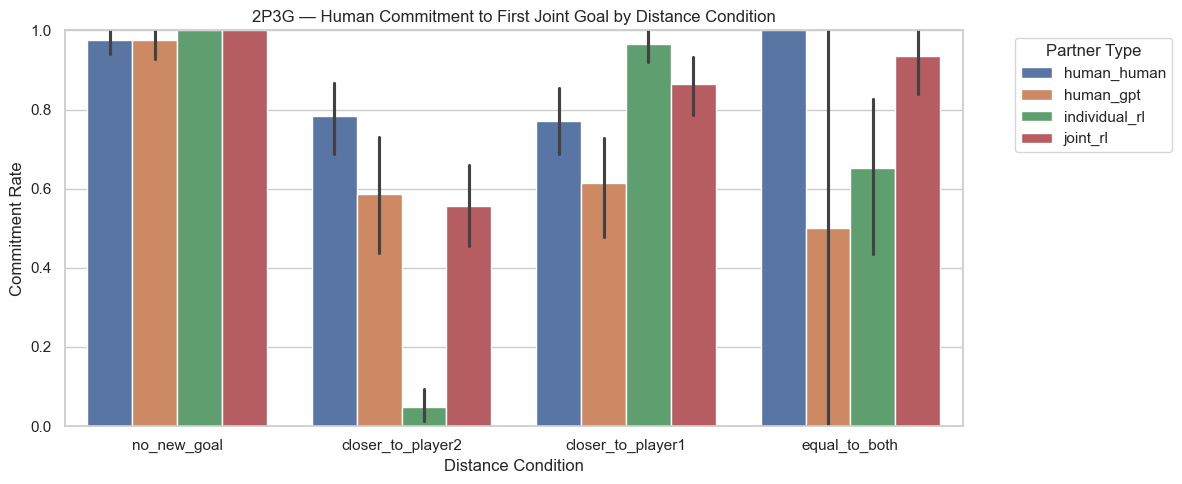

In [196]:
plt.figure(figsize=(12,5))
order = ['no_new_goal','closer_to_player2','closer_to_player1','equal_to_both']
hue_order = ['human_human','human_gpt','individual_rl','joint_rl']
sns.barplot(data=results, x='distanceCondition', y='commitment_human', hue='partner_group',
            order=order, hue_order=hue_order, errorbar=('ci',95))
plt.ylim(0,1)
plt.xlabel('Distance Condition')
plt.ylabel('Commitment Rate')
plt.title('2P3G — Human Commitment to First Joint Goal by Distance Condition')
plt.legend(title='Partner Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


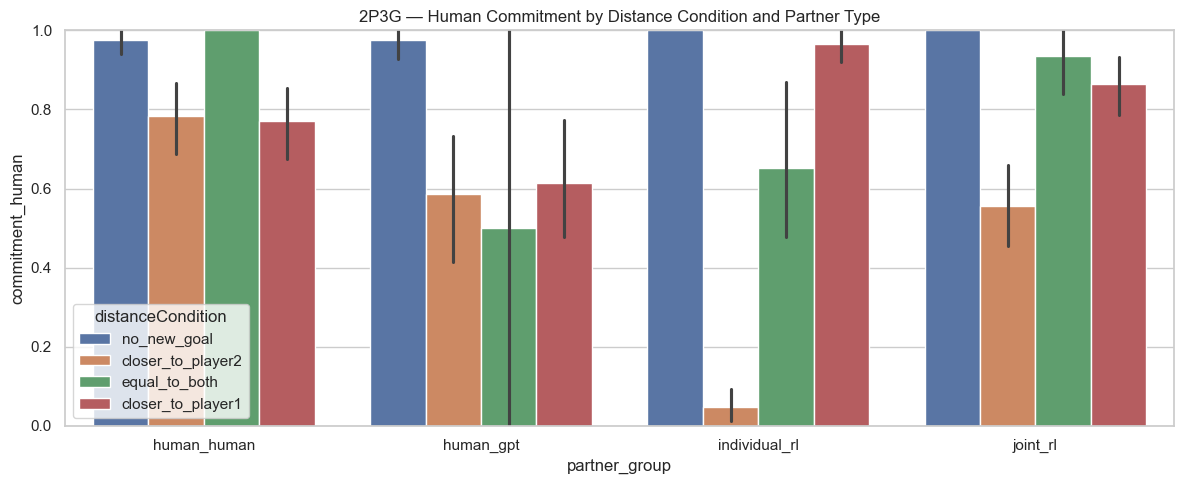

In [198]:
plt.figure(figsize=(12,5))
sns.barplot(data=results, x='partner_group', y='commitment_human', hue='distanceCondition',
            order=hue_order, hue_order=order, errorbar=('ci',95))
plt.ylim(0,1)
plt.title('2P3G — Human Commitment by Distance Condition and Partner Type')
plt.tight_layout()
plt.show()
